## Importe

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import jupyter_black

In [2]:
# Run Black for Better Formatting
jupyter_black.load()

In [3]:
# Display all columns
pd.set_option("display.max_columns", None)

In [4]:
# Importing File
fifa = (
    pd.read_csv("players_fifa23.csv")
    .drop_duplicates(subset=["FullName", "Club"])
    .reset_index()
)

## Data Cleaning

In [5]:
# Setting Full Name as Index
fifa2 = fifa.set_index("FullName")

In [6]:
# Selection of numeric attributes that are useful for player recommendation
fifa3 = fifa2._get_numeric_data()
fifa4 = fifa3.drop(
    [
        "ID",
        "Growth",
        "TotalStats",
        "BaseStats",
        "ValueEUR",
        "WageEUR",
        "ReleaseClause",
        "ContractUntil",
        "ClubNumber",
        "ClubJoined",
        "OnLoad",
        "NationalNumber",
        "IntReputation",
        "GKDiving",
        "GKHandling",
        "GKKicking",
        "GKPositioning",
        "GKReflexes",
        "STRating",
        "LWRating",
        "LFRating",
        "CFRating",
        "RFRating",
        "RWRating",
        "CAMRating",
        "LMRating",
        "CMRating",
        "RMRating",
        "LWBRating",
        "CDMRating",
        "RWBRating",
        "LBRating",
        "CBRating",
        "RBRating",
        "GKRating",
    ],
    axis=1,
)

In [7]:
# Minmax Scaling
scaler = MinMaxScaler()

fifa5 = pd.DataFrame(
    scaler.fit_transform(fifa4), columns=fifa4.columns, index=fifa4.index
)

In [8]:
# Weighting: Overall-Skill & Potential should get a higher weight
fifa5["Overall"] = fifa5["Overall"] * 4
fifa5["Potential"] = fifa5["Potential"] * 2

## Recommendation System

In [9]:
# Instanciating of KNN and Fitting with Dataset
knn = NearestNeighbors(metric="cosine")
knn.fit(fifa5)

NearestNeighbors(metric='cosine')

In [10]:
# Calculation of Distance and Rank with KNN
distance, rank = knn.kneighbors(fifa5, 11)

In [11]:
# Buiding a Dict with Player Index and Player Name
id_name = fifa["FullName"].to_dict()

In [12]:
# Column with Player Name and Club
id_name_club = fifa[["FullName", "Club"]].drop_duplicates()
id_name_club["Name and Club"] = (
    id_name_club.FullName + " " + "(" + id_name_club.Club + ")"
)
id_name_club = id_name_club["Name and Club"].to_dict()

In [13]:
# Building a DataFrame with the Distances between Players
dist_df = pd.DataFrame(
    columns=[f"rank_{i}" for i in range(1, 11)],
    index=fifa5.index,
    data=distance[:, 1:],
)

In [14]:
# Building a DataFrame with Indices of similar Players and mapping it to Players id_name
similar_df = pd.DataFrame(
    columns=[f"rank_{i}_name" for i in range(1, 11)],
    index=fifa5.index,
    data=rank[:, 1:],
).apply(lambda x: x.map(id_name))

In [15]:
# Building a DataFrame with Indices of similar Players and mapping it to Players id_name with Club
similar_with_club_df = pd.DataFrame(
    columns=[f"rank_{i}_name_club" for i in range(1, 11)],
    index=fifa5.index,
    data=rank[:, 1:],
).apply(lambda x: x.map(id_name_club))

In [16]:
# Joining the different DataFrames together
df_data = fifa4.join(similar_df).join(dist_df).join(similar_with_club_df)

In [17]:
# Droping rows with Nans
df_data = df_data.dropna(how="any")

In [18]:
def similar_player(player_name):
    player_name = df_data[df_data.index == player_name].index[0]

    ## Bar chart
    plt.figure(figsize=(12, 6))

    Xaxis = df_data.loc[player_name].values[-20:-10]
    Yaxis = df_data.loc[player_name].values[-10:]

    fig = sns.barplot(data=df_data, x=Xaxis, y=Yaxis, palette="mako")
    fig.set_title('Players similar to  " ' + str(player_name) + ' "')
    plt.show()

    ## Table display

    display_df = pd.concat(
        [
            df_data[df_data.index == player_name],
            df_data.loc[df_data.loc[player_name].values[43:53]],
        ]
    ).iloc[:, :43]

    display(display_df)

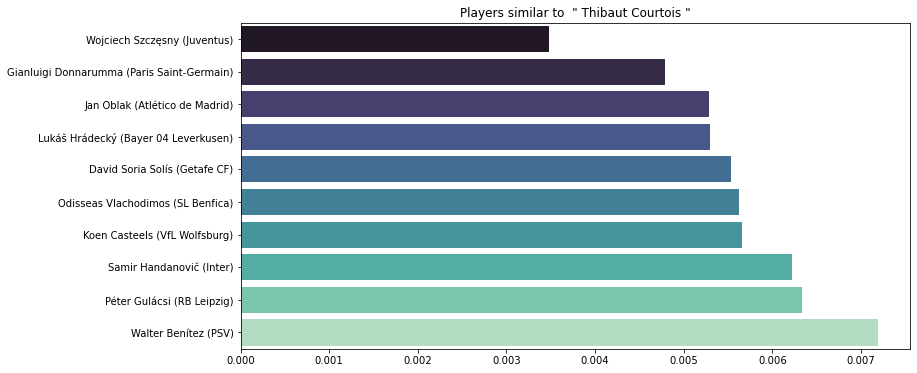

,index,Age,Height,Weight,Overall,Potential,WeakFoot,SkillMoves,PaceTotal,ShootingTotal,PassingTotal,DribblingTotal,DefendingTotal,PhysicalityTotal,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
FullName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Thibaut Courtois,6,30,199,96,90,91,3,1,84,89,75,90,46,89,14,14,13,33,12,13,19,20,35,23,42,52,63,84,45,56,68,38,70,17,23,15,13,44,27,66,20,18,16
Wojciech Szczęsny,51,32,195,90,86,86,3,1,86,81,73,87,49,86,12,12,16,32,14,11,16,14,36,22,51,47,55,82,51,55,71,45,65,14,40,15,14,48,18,65,20,13,12
Gianluigi Donnarumma,22,23,196,90,88,92,3,1,90,83,79,89,52,85,12,12,12,36,8,28,12,14,34,30,50,55,64,85,38,59,72,34,72,18,30,26,14,60,24,65,20,14,16
Jan Oblak,14,29,188,87,89,91,3,1,86,90,78,89,49,87,13,11,15,43,13,12,13,14,40,30,43,58,65,87,49,59,77,41,78,12,34,21,11,65,11,68,27,12,18
Lukáš Hrádecký,188,32,192,85,83,83,3,1,84,77,69,87,40,82,11,11,11,30,9,10,11,15,33,20,38,44,43,83,39,52,69,34,55,14,31,18,9,53,20,48,10,10,13
David Soria Solís,203,29,192,85,82,82,3,1,82,81,73,83,43,81,15,19,24,24,19,16,23,11,33,19,49,34,49,80,42,55,61,43,75,18,24,18,12,45,23,58,22,13,13
Odisseas Vlachodimos,355,28,190,81,81,83,3,1,84,78,67,84,43,78,15,12,13,27,14,13,17,13,24,23,42,44,67,82,38,50,74,39,68,16,32,23,14,46,18,56,17,14,12
Koen Casteels,113,30,197,86,84,85,2,1,84,82,79,86,45,84,15,15,14,35,13,14,20,13,37,23,44,46,50,80,43,59,58,44,72,18,33,16,15,42,20,40,11,19,17
Samir Handanovič,94,37,193,92,84,84,3,1,80,80,65,85,43,90,12,10,10,42,12,18,20,14,40,21,41,47,44,79,36,49,75,36,69,19,25,22,12,41,23,64,25,10,13


In [19]:
similar_player("Thibaut Courtois")